# N-body Results

Notebook for reading in the (processed) results of Gadget simulations and plotting them.

The results are found in the `data/` folder of the main BlackHolesDarkDress github repo, named `Mapping_M30_a0.01.txt`, etc. These results are obtained using `Nbody/CalcOrbitalElements.ipynb` tabulated manually (unfortunately).

The code loads in the `eddington` module, which contains information about the DM halo density profile.

### Some initialisation stuff:

In [1]:
from __future__ import print_function

%matplotlib inline

import numpy as np
import matplotlib as mpl
#matplotlib.use('Agg')
import matplotlib.pyplot as pl
import matplotlib.lines as mlines

import eddington as edd

from scipy.integrate import quad, dblquad
from scipy.interpolate import interp1d,interp2d,RectBivariateSpline, griddata

import matplotlib.ticker as ticker

from tqdm import tqdm
#import matplotlib.style
#mpl.style.use('classic')
#Change default font size so you don't need a magnifying glass
mpl.rc('font', **{'size'   : 18})

#font = {'family' : 'serif',
#        'size'   : 15}
#Edit to 16 here!

mpl.rcParams['xtick.major.size'] = 7
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 7
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['ytick.minor.width'] = 1
#mpl.rcParams['xtick.direction'] = 'in'
#mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rc('text', usetex=True)

mpl.rcParams['legend.edgecolor'] = 'inherit'

### Some function definitions, PDFs etc.

In [2]:
G_N = 4.302e-3 #(pc/solar mass) (km/s)^2

In [3]:
def calcj(e):
    return np.sqrt(1-e**2)

### Some functions of mapping from initial to final orbital parameters

In [4]:
#Calculating the halo binding energy down to some radius
def U_integ(r):
    return edd.Menc(r/edd.r_tr)*4.*np.pi*r**2*edd.rhoDM(r/edd.r_tr)/r

#Binding energy as a function of rmin,
#distance of closest approach
def U_bind(rmin):
    #Have to already have initialised eddington
    return -G_N*quad(U_integ, 0.5*rmin, 5*edd.r_tr)[0]



### Semi-major axis

   Calculating for M_PBH/M_sun =  1.0
   Calculating for M_PBH/M_sun =  30.0
   Calculating for M_PBH/M_sun =  1000.0
[ 0.43588989  0.14106736  0.04471018  0.01414178  0.00447212]


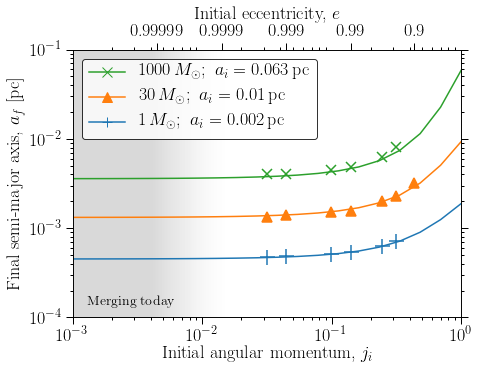

In [5]:
fig = pl.figure(figsize=(7,5.5))

jvals = np.logspace(-3, -0.0,20)

#pl.loglog(jvals, 10**(fit[1] + fit[0]*np.log10(jvals)))
    
#pl.semilogx(j_i_lo, a_f_lo, 'b^')
#pl.semilogx(j_i_hi, a_f_hi, 'r^')
Mvals = [1.0, 30.0, 1000.0]
a0vals = [0.002, 0.01, 0.063]
#cols = ['r','g','b']
cols = ['C0', 'C1', 'C2']

symbols = ['+', '^','x']
    
for M_PBH, a0,col,sym in zip(Mvals, a0vals, cols,symbols):
    print("   Calculating for M_PBH/M_sun = ", M_PBH)
    
    
    #Load in the N-body results
    a_i, e_i, a_f, e_f = np.loadtxt("../data/Mapping_M" + str(int(M_PBH)) + "_a" + str(a0) + ".txt" ,unpack=True)
    j_i = (1-e_i**2)**0.5
    j_f = (1-e_f**2)**0.5
    
    
    #Calculate the analytic estimates
    
    #First, need to initialise the halo properties...
    edd.loadDistribution(M_PBH, a0)
    
    rmin_vals = a0*(1-np.sqrt(1-jvals**2))
    Menc_vals = np.vectorize(edd.Menc)(0.5*rmin_vals/edd.r_tr)
    
    U_bind_vals = np.vectorize(U_bind)(rmin_vals)
    U_orb_before = -G_N*(edd.Menc(10)**2)/(2.0*a0)
    
    a_f_vals = -G_N*Menc_vals**2*0.5/(U_orb_before + 2.0*U_bind_vals)
    
    
    #pl.axhline(a0,linestyle='--', color='k')
    
    ms = 10
    if (sym=='+'):
        ms = 15
    pl.loglog(jvals, a_f_vals, '-', color=col)#, label='Analytic estimate')
    pl.loglog(j_i, a_f, '.', marker=sym,color=col, markersize=ms, mew=1.5)#, label="Simulations")



line3 = mlines.Line2D([], [], color=cols[0], marker=symbols[0],
                markersize=10, label=r'$'+str(int(Mvals[0])) + ' \,M_\odot;\,\,a_i = '+str(a0vals[0])+' \,\mathrm{pc}$')
line2 = mlines.Line2D([], [], color=cols[1], marker=symbols[1],
                markersize=10, label=r'$'+str(int(Mvals[1])) + ' \,M_\odot;\,\,a_i = '+str(a0vals[1])+' \,\mathrm{pc}$')
line1 = mlines.Line2D([], [], color=cols[2], marker=symbols[2],
                markersize=10, label=r'$'+str(int(Mvals[2])) + ' \,M_\odot;\,\,a_i = '+str(a0vals[2])+' \,\mathrm{pc}$')


#Sort out the legend
leg = pl.legend(handles=[line1,line2,line3])
    
    
#j_today = j_coal(a0, 13e9, M_PBH)
#pl.axvline(j_today, linestyle='--', color='k')
#pl.text(j_today*1.2, 0.006, r"$t_\mathrm{merge} \sim t_\mathrm{univ}$" )

pl.xlabel(r"Initial angular momentum, $j_i$")
pl.ylabel(r"Final semi-major axis, $a_f$ [pc]")
#pl.title(r"$M_\mathrm{PBH} = " + str(int(M_PBH)) + "\,M_\odot$; $\mathrm{a} = " + str(a0) + " \,\mathrm{pc}$", fontsize=18)

pl.ylim(1e-4, 1e-1)
pl.xlim(1e-3, 1)

#Add eccentricity axis
ax1 = pl.gca()
ax2 = ax1.twiny()
ax2.set_xlim(1e-3, 1)
ax2.set_xscale('log')
ax2.xaxis.set_ticks_position('top')
ax2.set_xlabel("Initial eccentricity, $e$")
eticks = np.array([0.9, 0.99, 0.999, 0.9999, 0.99999])
jticks = (1 - eticks**2)**0.5
print(jticks)
ax2.set_xticks(jticks)
ax2.set_xticklabels(eticks)


vals = np.ones(20)*1.0
vals = np.append(vals, np.linspace(1.0, 0.0,20))
vals = np.append(vals, np.zeros(60))

xgrid, ygrid = np.meshgrid(np.ones(100), vals)

#pl.figure()
#pl.plot(ygrid)
#pl.show()

ax1.contourf(np.logspace(-3, 0, 100), np.logspace(-4, -1, 100), ygrid.T,100, cmap='Greys', alpha=0.15)
#ax1.contourf(np.logspace(-3, 0, 100), np.logspace(-2, 0, 100), ygrid.T,100, cmap='Greys', alpha=0.05)
"""
ax1.fill_between([1e-3, 4e-3], 1e-2, 1, facecolor='grey', alpha = 0.25, zorder=0)
Nlines = 31
xlist = np.logspace(np.log10(4e-3), np.log10(2.0e-2), Nlines+1)
for i in range(Nlines):
    alph = 0.25*2.0/(1+np.exp(i*1.0/(0.2*Nlines)))
    
    ax1.fill_between([xlist[i], xlist[i+1]], 1e-2, 1, facecolor='grey', alpha = alph, zorder=0)
"""
#ax1.text(2.8e-3, 7e-1, "Merging today", va='center', ha='center', fontsize=14.0)



#ax1.fill_between([1e-3, 1e-2], 1e-4, 1e-1, facecolor='grey', alpha = 0.25, zorder=0)
ax1.text(2.8e-3, 1.5e-4, "Merging today", va='center', ha='center', fontsize=14.0)


pl.tight_layout()
pl.legend(loc='upper left')
pl.savefig("../plots/FinalSemiMajorAxis.pdf", bbox_inches='tight')
pl.show()    

### Final angular momentum

   Calculating for M_PBH/M_sun =  1.0
   Calculating for M_PBH/M_sun =  30.0
   Calculating for M_PBH/M_sun =  1000.0
[ 0.43588989  0.14106736  0.04471018  0.01414178  0.00447212]


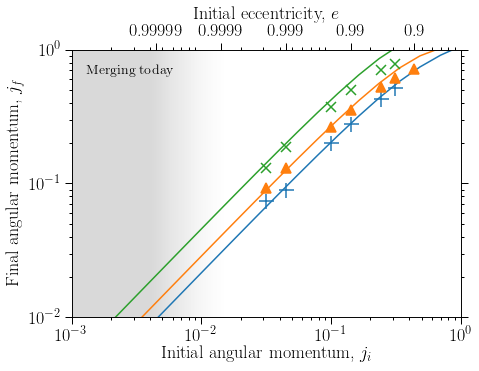

In [6]:
def calcL(M, a ,j):
    return (0.5*G_N*M**3*a*j**2)**0.5

def calcFinalj(a_ini, j_ini, kappa, M_PBH):
    rmin = a_ini*(1-np.sqrt(1-j_ini**2))
    Menc = edd.Menc(0.5*rmin/edd.r_tr)
    
    U_orb_before = -G_N*(edd.Menc(10)**2)/(2.0*a_ini)
    
    a_fin = -G_N*Menc**2*0.5/(U_orb_before + 2.0*U_bind(rmin))

    Mh = edd.Menc(10.0) - M_PBH
    L_ini = calcL(M_PBH + Mh, a_ini,j_ini)
    LDM_final = kappa + L_ini*Mh/(M_PBH + Mh)
    #LDM_final = kappa
    LPBH_final = np.clip(L_ini - LDM_final, 0, L_ini)
    #print LPBH_final
    
    #r_min = a_ini*(1-np.sqrt(1-j_ini**2))
    
    M_fin = M_PBH #+ M_PBH*(0.5*r_min/r_eq(M_PBH))**1.5
    #print M_fin
    return LPBH_final*(2.0/(G_N*M_fin**3*a_fin))**0.5



pl.figure(figsize=(7,5.5))

jvals = np.logspace(-3, -0.0,20)
    
Mvals = [1.0, 30.0, 1000.0]
a0vals = [0.002, 0.01, 0.063]
cols = ['C0', 'C1', 'C2']
symbols = ['+', '^','x']
    
for M_PBH, a0,col,sym in zip(Mvals, a0vals, cols,symbols):
    print("   Calculating for M_PBH/M_sun = ", M_PBH)
    
    #Load in N-body results
    a_i, e_i, a_f, e_f = np.loadtxt("../data/Mapping_M" + str(int(M_PBH)) + "_a" + str(a0) + ".txt" ,unpack=True)
    j_i = (1-e_i**2)**0.5
    j_f = (1-e_f**2)**0.5
    
    
    #First, need to initialise the halo properties...
    edd.loadDistribution(M_PBH, a0)
    

    
    
    j_f_anal = np.vectorize(calcFinalj)(a0, jvals, kappa=0.0, M_PBH = M_PBH)
    #print "...exponent:", fit[0]


    pl.loglog(jvals, j_f_anal, color=col, linestyle='-')#, label='Analytic estimate')
    #pl.loglog(j_in, j_f_anal_2)

    ms = 10
    if (sym == '+'):
        ms = 15
    pl.loglog(j_i, j_f, '.',marker=sym, markersize=ms, mew=1.5,alpha=1.0,color=col)#, label='Simulations')
#pl.loglog(j_i_lo, j_f_lo, 'bx', markersize=10, label="Low-res")
#pl.loglog(j_i_hi, j_f_hi, 'r+', markersize=10, label="High-res")

#pl.loglog(jvals, 10**(fit[1] + fit[0]*np.log10(jvals)), ':')
    
    
pl.xlabel(r"Initial angular momentum, $j_i$")
pl.ylabel(r"Final angular momentum, $j_f$")

pl.ylim(1e-2, 1)
pl.xlim(1e-3, 1)


#j_today = j_coal(a0, 13e9, M_PBH)
#pl.axvline(j_today, linestyle='--', color='k')
#pl.text(j_today*1.2, j_today*70.1, r"$t_\mathrm{merge} \sim t_\mathrm{univ}$" )

#pl.legend(loc = "lower right", fancybox=True)
#pl.title(r"$M_\mathrm{PBH} = " + str(int(M_PBH)) + "\,M_\odot$; $\mathrm{a} = " + str(a0) + " \,\mathrm{pc}$",fontsize=18)

line3 = mlines.Line2D([], [], color=cols[0], marker=symbols[0],
                markersize=10, label=r'$'+str(int(Mvals[0])) + ' \,M_\odot;\,\,a_i = '+str(a0vals[0])+' \,\mathrm{pc}$')
line2 = mlines.Line2D([], [], color=cols[1], marker=symbols[1],
                markersize=10, label=r'$'+str(int(Mvals[1])) + ' M_\odot;\,\,a_i = '+str(a0vals[1])+' \,\mathrm{pc}$')
line1 = mlines.Line2D([], [], color=cols[2], marker=symbols[2],
                markersize=10, label=r'$'+str(int(Mvals[2])) + ' M_\odot;\,\,a_i = '+str(a0vals[2])+' \,\mathrm{pc}$')


#Add eccentricity axis
ax1 = pl.gca()
ax2 = ax1.twiny()
ax2.set_xlim(1e-3, 1)
ax2.set_xscale('log')
ax2.xaxis.set_ticks_position('top')
ax2.set_xlabel("Initial eccentricity, $e$")
eticks = np.array([0.9, 0.99, 0.999, 0.9999, 0.99999])
jticks = (1 - eticks**2)**0.5
print(jticks)
ax2.set_xticks(jticks)
ax2.set_xticklabels(eticks)

vals = np.ones(20)*1.0
vals = np.append(vals, np.linspace(1.0, 0.0,20))
vals = np.append(vals, np.zeros(60))

xgrid, ygrid = np.meshgrid(np.ones(100), vals)

#pl.figure()
#pl.plot(ygrid)
#pl.show()

ax1.contourf(np.logspace(-3, 0, 100), np.logspace(-2, 0, 100), ygrid.T,100, cmap='Greys', alpha=0.15)
#ax1.contourf(np.logspace(-3, 0, 100), np.logspace(-2, 0, 100), ygrid.T,100, cmap='Greys', alpha=0.05)
"""
ax1.fill_between([1e-3, 4e-3], 1e-2, 1, facecolor='grey', alpha = 0.25, zorder=0)
Nlines = 31
xlist = np.logspace(np.log10(4e-3), np.log10(2.0e-2), Nlines+1)
for i in range(Nlines):
    alph = 0.25*2.0/(1+np.exp(i*1.0/(0.2*Nlines)))
    
    ax1.fill_between([xlist[i], xlist[i+1]], 1e-2, 1, facecolor='grey', alpha = alph, zorder=0)
"""
ax1.text(2.8e-3, 7e-1, "Merging today", va='center', ha='center', fontsize=14.0)

#Sort out the legend
#pl.legend(handles=[line1,line2,line3],loc='lower right')

pl.tight_layout()
pl.savefig("../plots/FinalAngularMomentum.pdf", bbox_inches='tight')
pl.show()